# model: Random forest

In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skopt.space import Real
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Develop the Model

### 1.1 Load and Prepare the Data

First, you need to load your data from the Excel file and prepare it for analysis. This involves cleaning, possibly transforming the data, and splitting it into training and testing sets.

In [4]:
#pip install openpyxl

data = pd.read_excel('Data.xlsx')
data.head(2)
#print(data)

,Test number,Qf,Qs_m^3/hr,H_cm,ρs,Vfrontal_cm/s,Reo,F,Frdens,Location,Group,ABC,Qa/Qs,Position/H
0,1,1.92,0.1,23,1.006,4.637682,10613.600796,0.030875,0.379927,50,1,0.22,0.131974,2.173913
1,2,1.92,0.1,23,1.008,4.637682,10613.600796,0.030875,0.332830,50,1,0.34,0.203959,2.173913


In [5]:
# Display the statistical summary of specific columns in the dataframe
columns_to_describe = ['Reo', 'F', 'Frdens', 'Location', 'ABC']
data_summary = data[columns_to_describe].describe()
data_summary

,Reo,F,Frdens,Location,ABC
count,81.000000,81.000000,81.000000,81.000000,81.000000
mean,11276.950846,0.030843,0.337165,75.000000,0.361864
std,544.997679,0.002177,0.040796,20.539596,0.106226
min,10613.600796,0.027245,0.264546,50.000000,0.140000
25%,10613.600796,0.028965,0.299791,50.000000,0.300000
50%,11276.950846,0.030776,0.332830,75.000000,0.350000
75%,11940.300896,0.032586,0.374434,100.000000,0.420000
max,11940.300896,0.034734,0.427418,100.000000,0.600000


In [6]:

data['ρs'] = pd.to_numeric(data['ρs'], errors='coerce')
data['H_cm'] = pd.to_numeric(data['H_cm'], errors='coerce')
data['Qf'] = pd.to_numeric(data['Qf'], errors='coerce')

data['Reo'] = pd.to_numeric(data['Reo'], errors='coerce')
data['Fr'] = pd.to_numeric(data['F'], errors='coerce')
data['Frdens'] = pd.to_numeric(data['Frdens'], errors='coerce')
data['Location'] = pd.to_numeric(data['Location'], errors='coerce')
data['Qa'] = pd.to_numeric(data['ABC'], errors='coerce')
data['Qa/Qs'] = pd.to_numeric(data['Qa/Qs'], errors='coerce')
data['Position/H'] = pd.to_numeric(data['Position/H'], errors='coerce')

# Drop rows where any of the converted columns is NaN
data.dropna(subset=['Reo', 'Fr', 'Frdens', 'Location', 'Qa', 'Qa/Qs', 'Position/H'], inplace=True)

### plot 

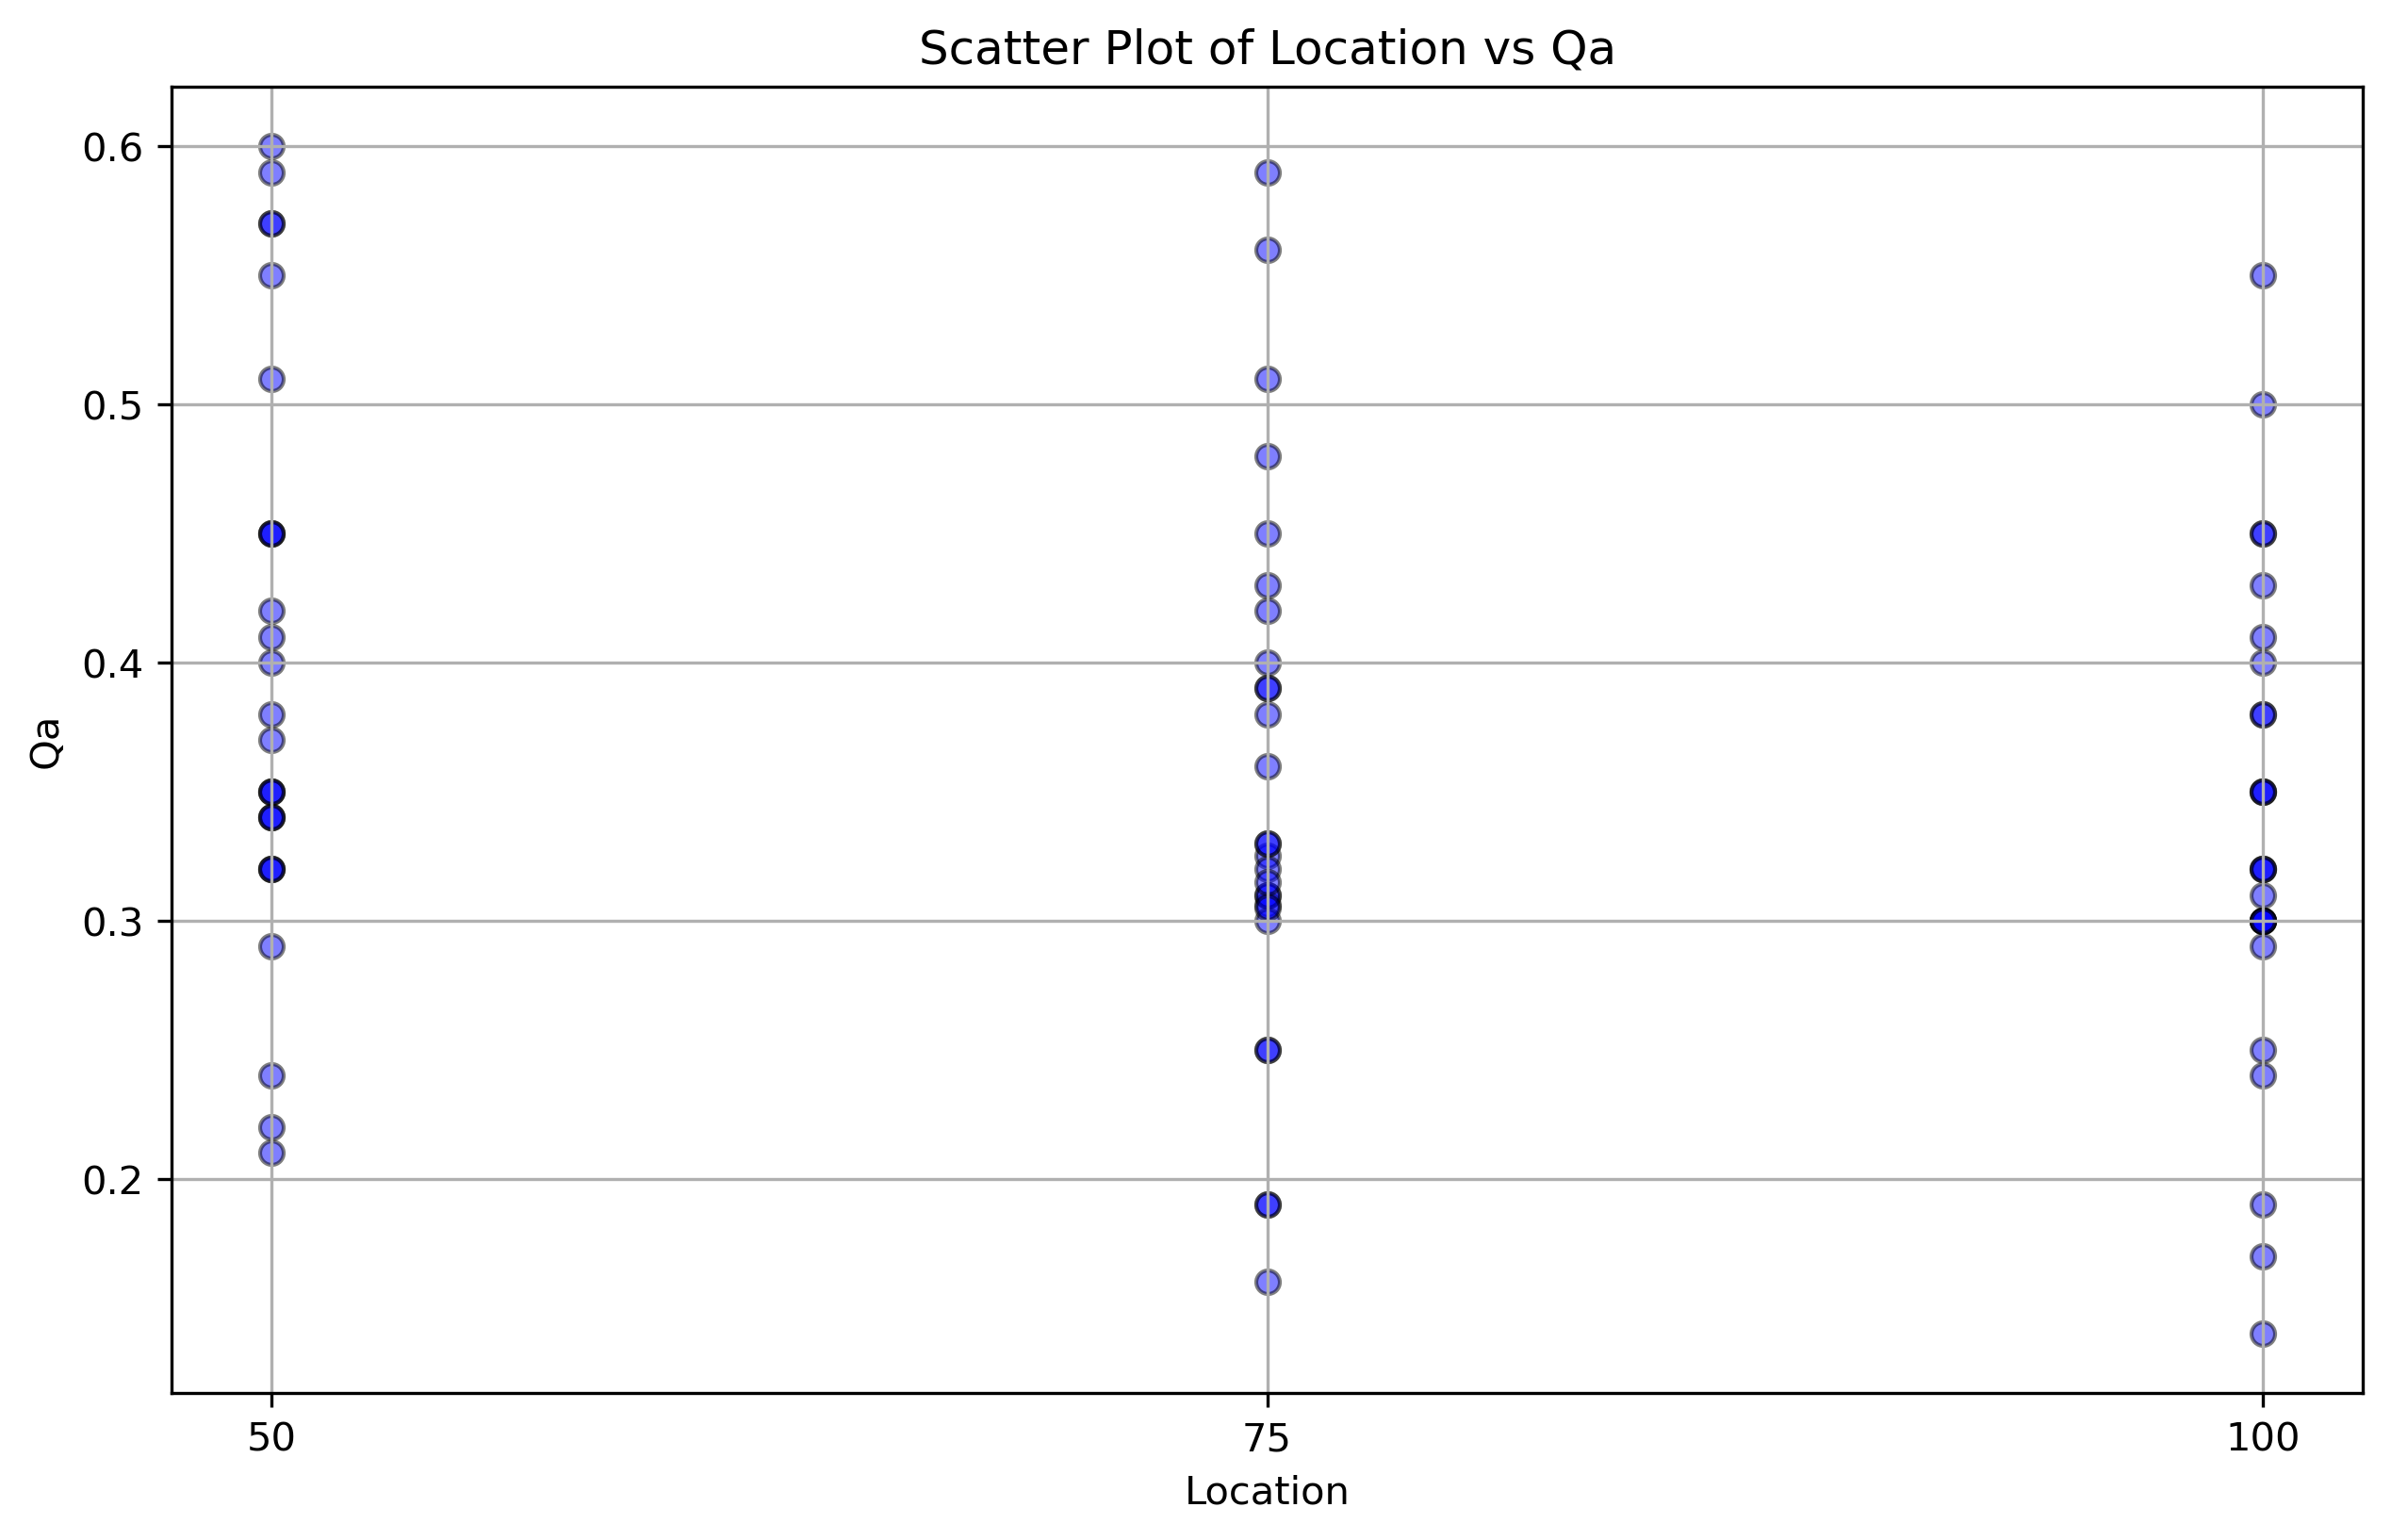

In [7]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(data['Location'], data['Qa'], c='blue', alpha=0.5, edgecolor='k')
plt.xlabel('Location')
plt.ylabel('Qa')
plt.title('Scatter Plot of Location vs Qa')
plt.grid(True)
plt.xticks([50, 75, 100])  # Ensuring only valid location values are shown on the x-axis
plt.show()


### 1.2  Train/Test the Model and Metric to evalute the model: 
Train two models, but remember L will be predicted from both yet is based on the same data.

# Step 3: Simulate Different Scenarios

# Random Forest ####

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Extract relevant columns
X = data[['ρs',
          'H_cm',
          'Qf',
          'Reo', 
          'F', 
          'Frdens', 
          'Location'
         ]]
y = data[['ABC']]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# Train the model with best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
base_model = RandomForestRegressor(random_state=42)
model = MultiOutputRegressor(base_model)

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Generating predictions for locations 51 to 99
new_locations = np.arange(51, 100)
predictions = []

for loc in new_locations:
    for i in range(27):  # Using 27 tests for each location
        # Extract one of the original data rows and modify the location
        new_data = data.iloc[i][['ρs','H_cm', 'Qf', 'Reo', 'F', 'Frdens']].tolist() + [loc]
        new_data_scaled = scaler.transform([new_data])
        predicted_abc = best_model.predict(new_data_scaled)
        predictions.append({
                        'ρs': new_data[0],
                        'H_cm': new_data[1],
                        'Qf': new_data[2],
            'Reo': new_data[3],
            'F': new_data[4],
            'Frdens': new_data[5],
            'Location': loc,
            'ABC': predicted_abc[0, 0]
        })

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Save predictions to a file
predictions_file_path = 'Predictions_from_51_to_99.xlsx'
predictions_df.to_excel(predictions_file_path, index=False)

# Calculate metrics
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Initialize dictionary to store results
results = {
    'Model': ['Random Forest'],
    'Train MAE ABC': [train_mae],
    'Train RMSE ABC': [train_rmse],
    'Train R-squared ABC': [train_r2],
    'Test MAE ABC': [test_mae],
    'Test RMSE ABC': [test_rmse],
    'Test R-squared ABC': [test_r2]
}

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

predictions_file_path


/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/

/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/

/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/

/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/

'Predictions_from_51_to_99.xlsx'

In [9]:
# Display the results DataFrame
results_df

,Model,Train MAE ABC,Train RMSE ABC,Train R-squared ABC,Test MAE ABC,Test RMSE ABC,Test R-squared ABC
0,Random Forest,0.009218,0.014233,0.98291,0.02752,0.036306,0.820665


In [10]:
data = pd.read_excel('Predictions_from_51_to_99.xlsx')
data.head(2)

,ρs,H_cm,Qf,Reo,F,Frdens,Location,ABC
0,1.006,23,1.92,10613.600796,0.030875,0.379927,51,0.2028
1,1.008,23,1.92,10613.600796,0.030875,0.332830,51,0.3416


In [11]:
import pandas as pd

# Load the predictions dataset
predictions_df = pd.read_excel('Predictions_from_51_to_99.xlsx')

# Inspect the data types
print(predictions_df.dtypes)

# Convert ABC to numeric if it's not already
if not pd.api.types.is_numeric_dtype(predictions_df['ABC']):
    predictions_df['ABC'] = pd.to_numeric(predictions_df['ABC'], errors='coerce')

# Calculate the average value of ABC for rows where the Location is the same
average_abc = predictions_df.groupby('Location')['ABC'].mean().reset_index()

average_abc.head()



ρs          float64
H_cm          int64
Qf          float64
Reo         float64
F           float64
Frdens      float64
Location      int64
ABC         float64
dtype: object


,Location,ABC
0,51,0.389311
1,52,0.389311
2,53,0.389311
3,54,0.389311
4,55,0.389311


In [12]:
# Load the predictions dataset
predictions_df = pd.read_excel('Predictions_from_51_to_99.xlsx')

# Convert ABC to numeric if it's not already
predictions_df['ABC'] = pd.to_numeric(predictions_df['ABC'], errors='coerce')

# Calculate the average value of ABC for rows where the Location is the same
results_df = predictions_df.groupby('Location')['ABC'].mean().reset_index()

# Convert Location to numeric if it's not already
results_df['Location'] = pd.to_numeric(average_abc['Location'], errors='coerce')

# Inspect the average_abc DataFrame to ensure it is correct
print(average_abc.head())

   Location       ABC
0        51  0.389311
1        52  0.389311
2        53  0.389311
3        54  0.389311
4        55  0.389311


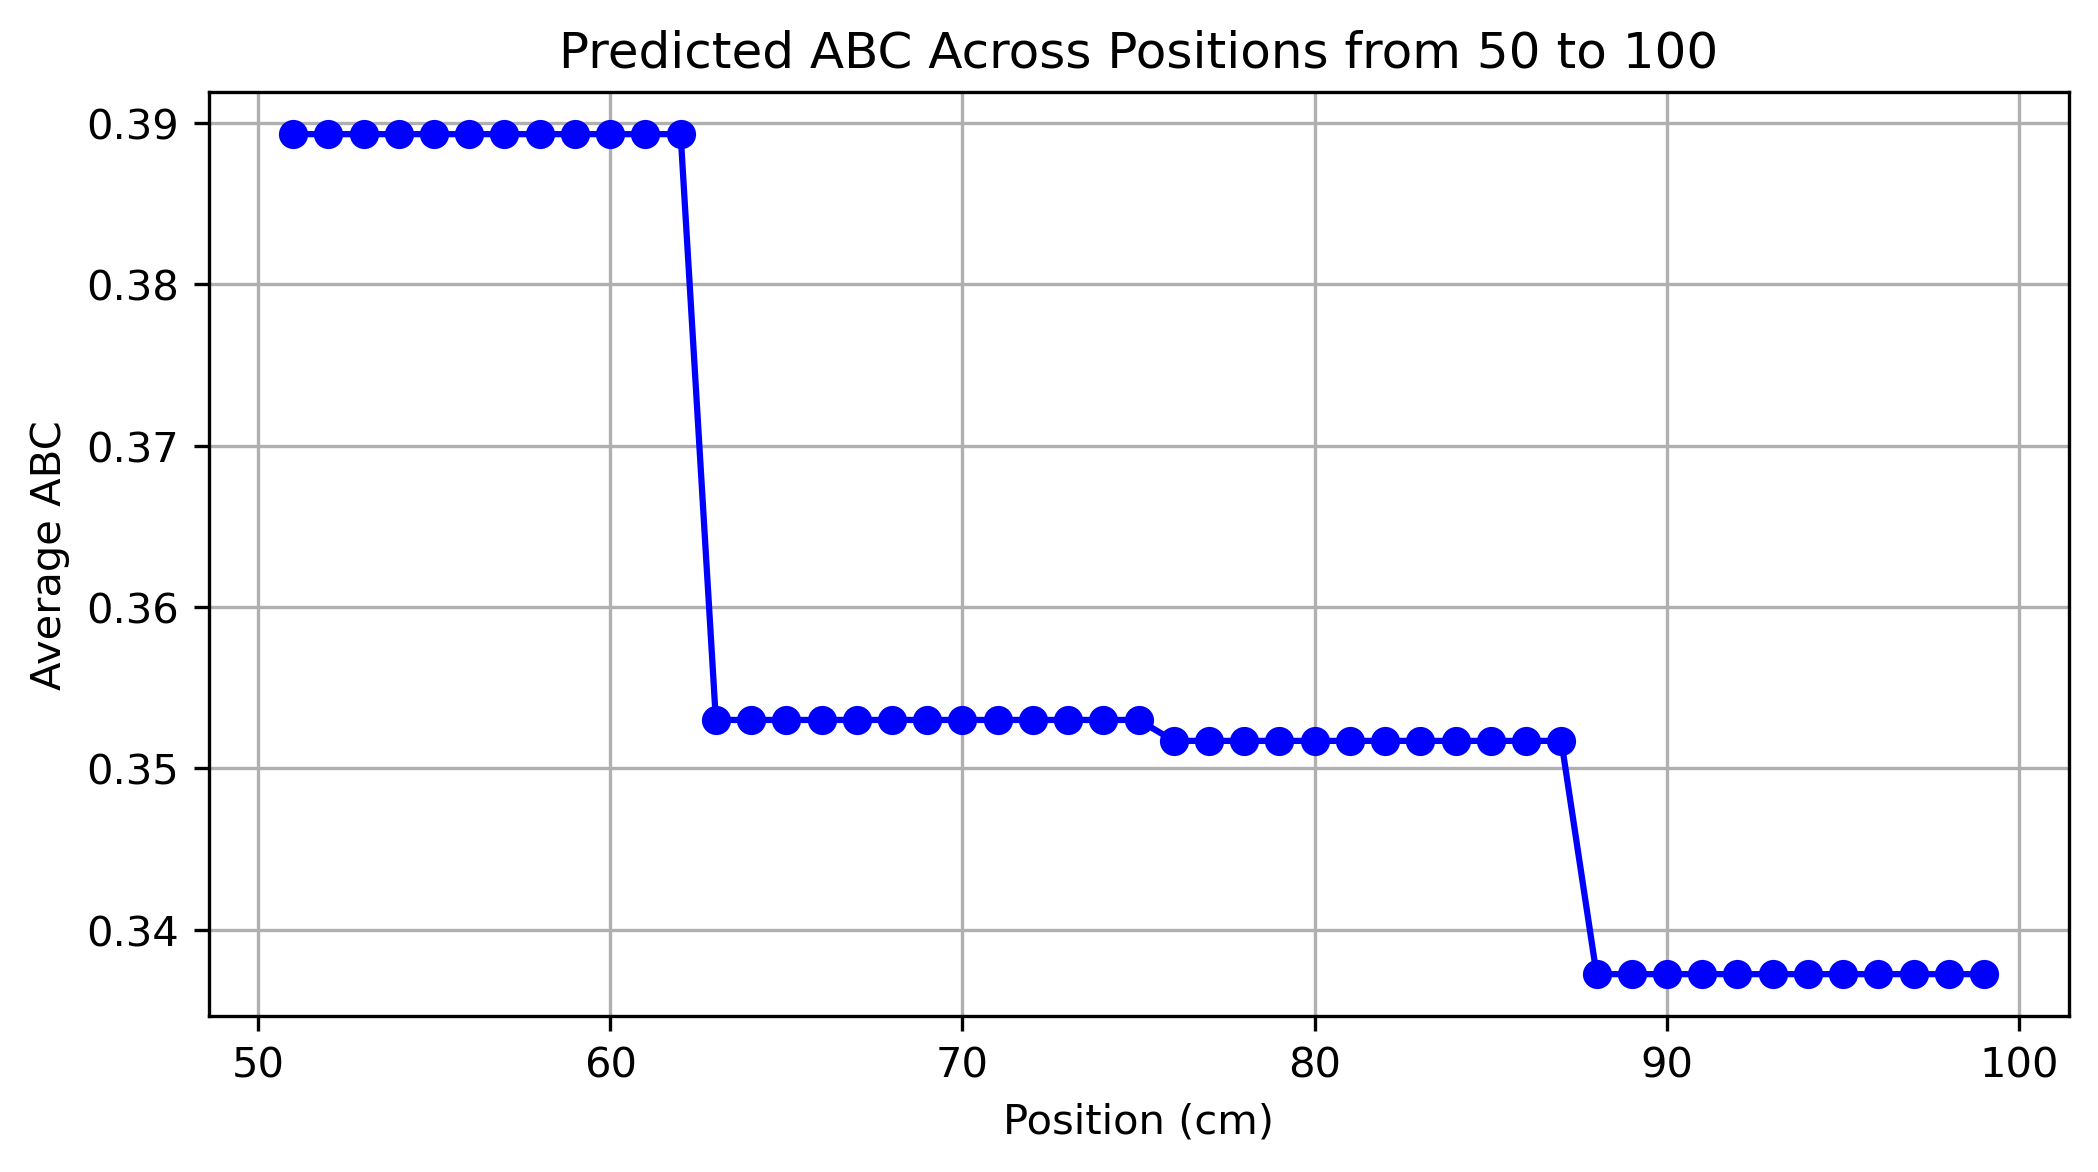

In [13]:
# Plotting the average ABC values by Location
plt.figure(figsize=(8, 4), dpi=300) 
plt.plot(results_df['Location'], results_df['ABC'], marker='o', linestyle='-', color='b')
plt.title('Predicted ABC Across Positions from 50 to 100')  # Title of the plot
plt.xlabel('Position (cm)')  # X-axis label
plt.ylabel('Average ABC')  # Y-axis label
plt.grid(True)
plt.show()

### old simulation

# Step 4: Calculating Non-dimention ratio:

In [14]:
# Add a new column that is Position divided by H_avg
results_df['Position/H_avg'] = results_df['Location'] / 24
results_df['Qa_Predicted (avg)/Qs_avg'] = results_df['ABC'] / (0.1*16.67) # 16.67 is converting coffecient from the m^3/h to lit/min

# Display the updated DataFrame to verify the new column
results_df.head()

,Location,ABC,Position/H_avg,Qa_Predicted (avg)/Qs_avg
0,51,0.389311,2.125000,0.23354
1,52,0.389311,2.166667,0.23354
2,53,0.389311,2.208333,0.23354
3,54,0.389311,2.250000,0.23354
4,55,0.389311,2.291667,0.23354


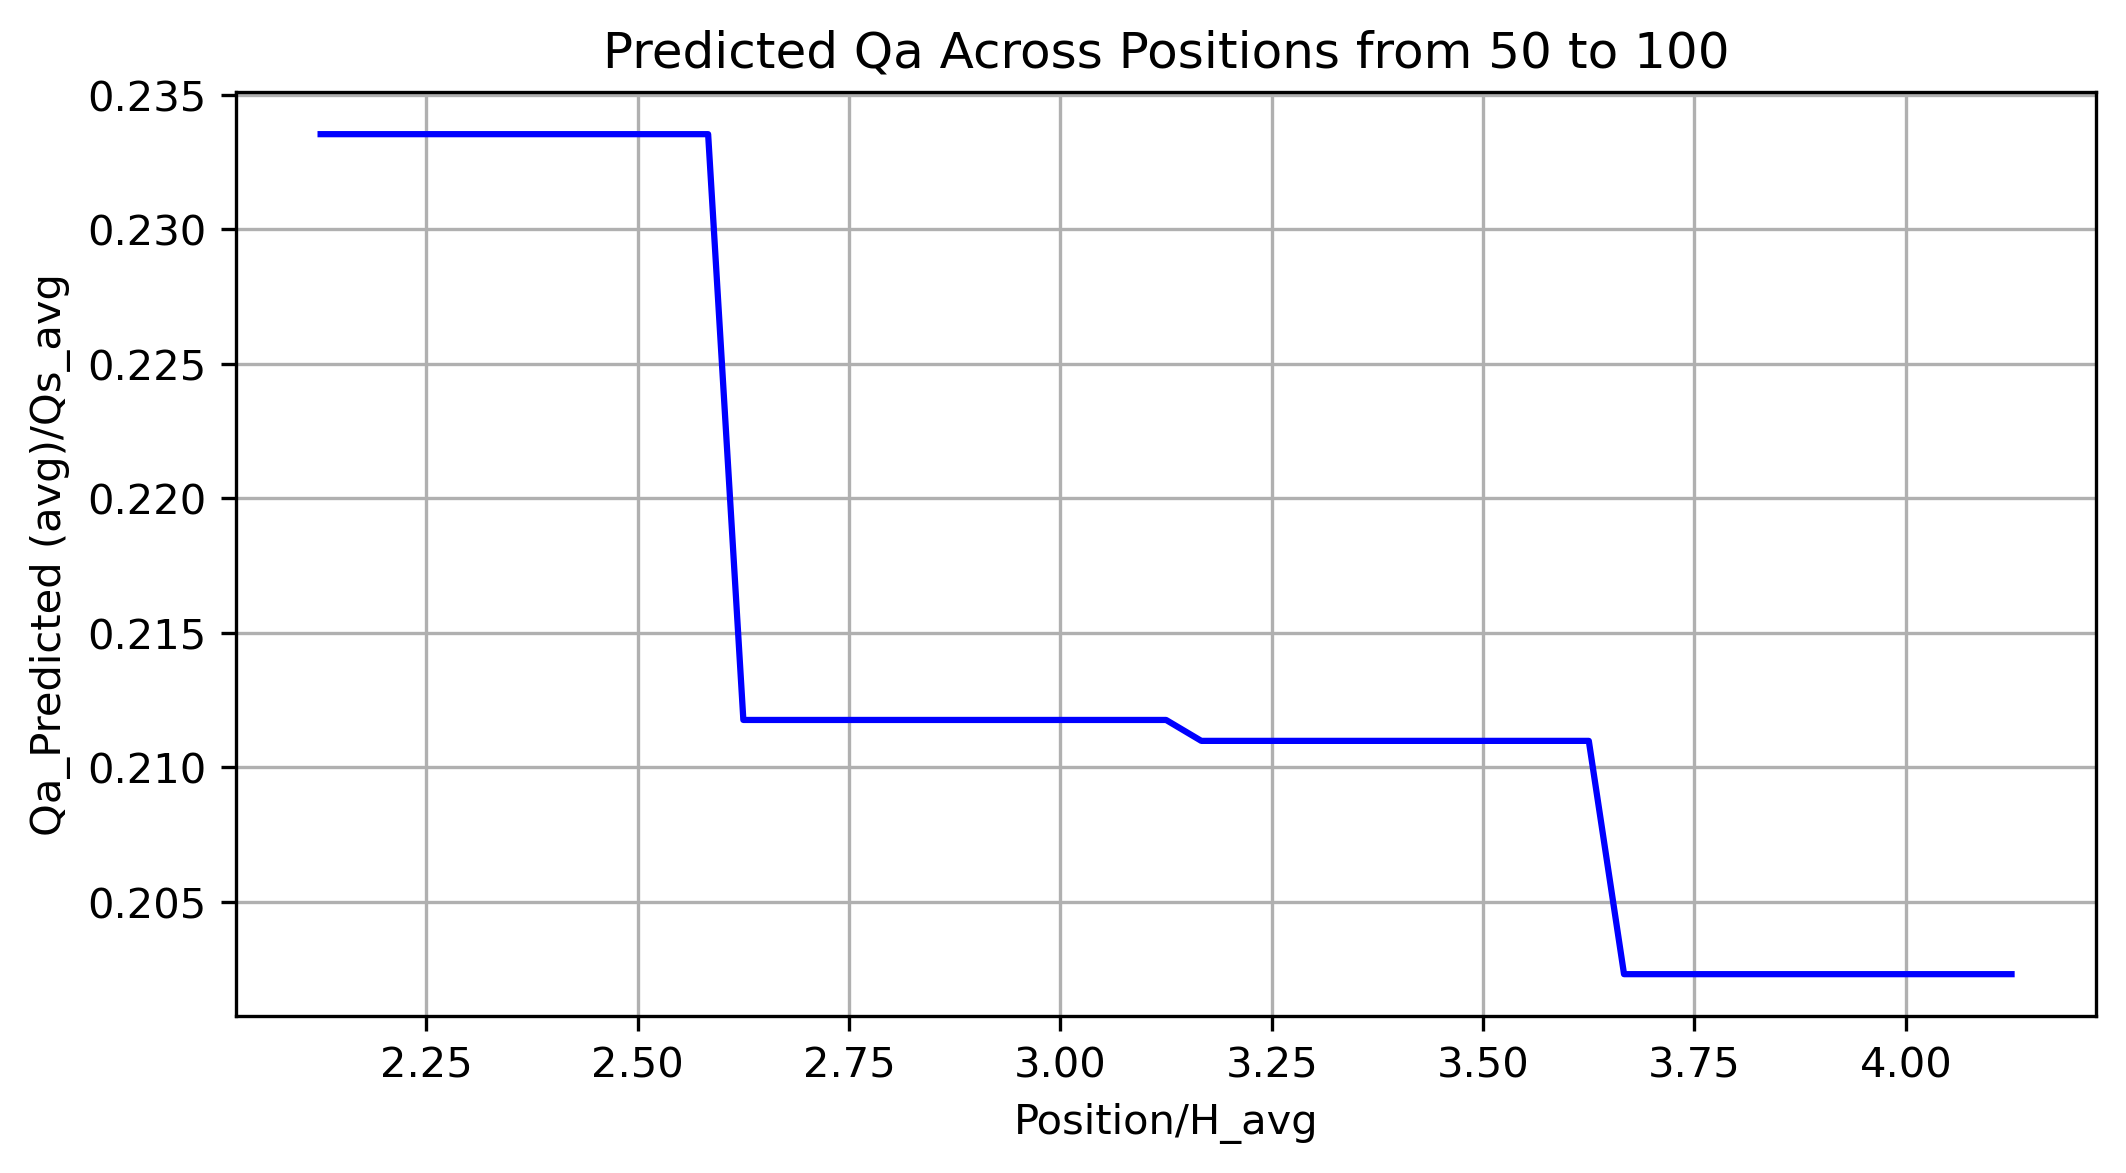

In [15]:
plt.figure(figsize=(8, 4), dpi=300) 
plt.plot(results_df['Position/H_avg'], results_df['Qa_Predicted (avg)/Qs_avg'], 
         #marker='o', 
         linestyle='-', 
         color='b'
        )
plt.title('Predicted Qa Across Positions from 50 to 100')  # Title of the plot
plt.xlabel('Position/H_avg')  # X-axis label
plt.ylabel('Qa_Predicted (avg)/Qs_avg')  # Y-axis label
plt.grid(True)  # Enable grid for easier visualization
plt.show()  # Display the plot

# Step 5: Decision Making
Analyze results to optimize Location and Qa.

In [16]:
# Normalize the metrics (scale between 0 and 1)
results_df['Normalized Position/H_avg'] = (results_df['Position/H_avg'] - results_df['Position/H_avg'].min()) / (results_df['Position/H_avg'].max() - results_df['Position/H_avg'].min())
results_df['Normalized Qa_Predicted (avg)/Qs_avg'] = (results_df['Qa_Predicted (avg)/Qs_avg'] - results_df['Qa_Predicted (avg)/Qs_avg'].min()) / (results_df['Qa_Predicted (avg)/Qs_avg'].max() - results_df['Qa_Predicted (avg)/Qs_avg'].min())

# Combine the normalized metrics into a single decision score (simple sum)
#results_df['Decision Score'] = (results_df['Normalized Position/H_avg']*0.9) + (results_df['Normalized Qa_Predicted (avg)/Qs_avg']*1.1)


results_df['Decision Score'] = results_df['Normalized Position/H_avg'] + results_df['Normalized Qa_Predicted (avg)/Qs_avg']





# Find the position with the lowest decision score
optimal_position = results_df.loc[results_df['Decision Score'].idxmin()]

print("Optimal Position for Installing ABC:")
print(optimal_position)

Optimal Position for Installing ABC:
Location                                63.000000
ABC                                      0.353005
Position/H_avg                           2.625000
Qa_Predicted (avg)/Qs_avg                0.211761
Normalized Position/H_avg                0.250000
Normalized Qa_Predicted (avg)/Qs_avg     0.302634
Decision Score                           0.552634
Name: 12, dtype: float64


In [17]:
#'Position' = 'Location'

In [18]:
# Normalize the metrics (scale between 0 and 1)
results_df['Normalized Position'] = (results_df['Location'] - results_df['Location'].min()) / (results_df['Location'].max() - results_df['Location'].min())
results_df['Normalized Qa_Predicted'] = (results_df['ABC'] - results_df['ABC'].min()) / (results_df['ABC'].max() - results_df['ABC'].min())

# Combine the normalized metrics into decision scores for different scenarios
results_df['Decision Score'] = results_df['Normalized Position'] + results_df['Normalized Qa_Predicted']
results_df['Decision Score (0.8+1.2)'] = (results_df['Normalized Position']*0.8) + (results_df['Normalized Qa_Predicted']*1.2)
results_df['Decision Score (1.2+0.8)'] = (results_df['Normalized Position']*1.2) + (results_df['Normalized Qa_Predicted']*0.8)
results_df['Decision Score (0.6+1.4)'] = (results_df['Normalized Position']*0.6) + (results_df['Normalized Qa_Predicted']*1.4)
results_df['Decision Score (1.4+0.6)'] = (results_df['Normalized Position']*1.4) + (results_df['Normalized Qa_Predicted']*0.6)

# Find the positions with the lowest decision scores for each scenario
optimal_position = results_df.loc[results_df['Decision Score'].idxmin()]
optimal_position_0_8_1_2 = results_df.loc[results_df['Decision Score (0.8+1.2)'].idxmin()]
optimal_position_1_2_0_8 = results_df.loc[results_df['Decision Score (1.2+0.8)'].idxmin()]
optimal_position_0_6_1_4 = results_df.loc[results_df['Decision Score (0.6+1.4)'].idxmin()]
optimal_position_1_4_0_6 = results_df.loc[results_df['Decision Score (1.4+0.6)'].idxmin()]

# Combine the optimal positions into a DataFrame
optimal_positions_df = pd.DataFrame({
    'Scenario (Position+Qa)': ['1+1', '0.8+1.2', '1.2+0.8', '0.6+1.4', '1.4+0.6'],
    'Position': [optimal_position['Location'], 
                 optimal_position_0_8_1_2['Location'], 
                 optimal_position_1_2_0_8['Location'], 
                 optimal_position_0_6_1_4['Location'], 
                 optimal_position_1_4_0_6['Location']],
    'Predicted ABC': [optimal_position['ABC'], 
                      optimal_position_0_8_1_2['ABC'], 
                      optimal_position_1_2_0_8['ABC'], 
                      optimal_position_0_6_1_4['ABC'], 
                      optimal_position_1_4_0_6['ABC']],
    'Normalized Position': [optimal_position['Normalized Position'], 
                            optimal_position_0_8_1_2['Normalized Position'], 
                            optimal_position_1_2_0_8['Normalized Position'], 
                            optimal_position_0_6_1_4['Normalized Position'], 
                            optimal_position_1_4_0_6['Normalized Position']],
    'Normalized Qa_Predicted': [optimal_position['Normalized Qa_Predicted'], 
                                optimal_position_0_8_1_2['Normalized Qa_Predicted'], 
                                optimal_position_1_2_0_8['Normalized Qa_Predicted'], 
                                optimal_position_0_6_1_4['Normalized Qa_Predicted'], 
                                optimal_position_1_4_0_6['Normalized Qa_Predicted']],
    'Decision Score': [optimal_position['Decision Score'], 
                       optimal_position_0_8_1_2['Decision Score (0.8+1.2)'], 
                       optimal_position_1_2_0_8['Decision Score (1.2+0.8)'], 
                       optimal_position_0_6_1_4['Decision Score (0.6+1.4)'], 
                       optimal_position_1_4_0_6['Decision Score (1.4+0.6)']]
})

# Display the DataFrame
optimal_positions_df


,Scenario (Position+Qa),Position,Predicted ABC,Normalized Position,Normalized Qa_Predicted,Decision Score
0,1+1,63.0,0.353005,0.250000,0.302634,0.552634
1,0.8+1.2,63.0,0.353005,0.250000,0.302634,0.563160
2,1.2+0.8,63.0,0.353005,0.250000,0.302634,0.542107
3,0.6+1.4,88.0,0.337250,0.770833,0.000000,0.462500
4,1.4+0.6,63.0,0.353005,0.250000,0.302634,0.531580


# The End